# CSE 258 HW 2
## Pin Tian A53219987

In [1]:
import numpy as np
from urllib.request import urlopen
import scipy.optimize
from math import exp
from math import log
import matplotlib.pyplot as plt

def parseData(fname):
    for l in urlopen(fname):
        yield eval(l)

print("Reading data...")
data = list(parseData("http://jmcauley.ucsd.edu/cse190/data/beer/beer_50000.json"))
print("done")

Reading data...
done


In [2]:
def inner(x,y):
    return sum([x[i]*y[i] for i in range(len(x))])

def sigmoid(x):
    return 1.0 / (1 + np.exp(-x))

##################################################
# Logistic regression by gradient ascent         #
##################################################
# NEGATIVE Log-likelihood
def f(theta, X, y, lam):
    loglikelihood = 0
    for i in range(len(X)):
        logit = inner(X[i], theta)
        loglikelihood -= log(1 + exp(-logit))
        if not y[i]:
            loglikelihood -= logit
    for k in range(len(theta)):
        loglikelihood -= lam * theta[k]*theta[k]
    # for debugging
#     print("ll =" + str(loglikelihood))
    return -loglikelihood

# NEGATIVE Derivative of log-likelihood
def fprime(theta, X, y, lam):
    dl = [0]*len(theta)
    for i in range(len(X)):
        logit = inner(X[i], theta)
        for k in range(len(theta)):
            dl[k] += X[i][k] * (1 - sigmoid(logit))
            if not y[i]:
                dl[k] -= X[i][k]
    for k in range(len(theta)):
        dl[k] -= lam*2*theta[k]
    return np.array([-x for x in dl])



##################################################
# Train                                          #
##################################################

def train(lam):
    theta,_,_ = scipy.optimize.fmin_l_bfgs_b(f, [0]*len(X[0]), fprime, pgtol = 10, 
                                             args = (X_train, y_train, lam))
    return theta

##################################################
# Predict                                        #
##################################################

def performance(theta,X,y):
    scores = [inner(theta,x) for x in X]
    predictions = [s > 0 for s in scores]
    correct = [(a==b) for (a,b) in zip(predictions,y)]
    acc = sum(correct) * 1.0 / len(correct)
    return acc

def BER(theta,X,y):
    scores = [inner(theta,x) for x in X]
    predictions = [s > 0 for s in scores]
    tp = sum([(a==b==True) for (a,b) in zip(predictions,y)])
    tn = sum([(a==b==False) for (a,b) in zip(predictions,y)])
    fp = sum([(a==True and b==False) for (a,b) in zip(predictions,y)])
    fn = sum([(a==False and b==True) for (a,b) in zip(predictions,y)])
    ber = 1.0 - 0.5*tp/(fn+tp)-0.5*tn/(fp+tn)
    return ber,tp,tn,fp,fn
print ('done')

done


## Problem 1

We got a very weird results and the reason, I think,is that the imbalance of the data

In [3]:
def feature(datum):
    feat = [1, datum['review/taste'], datum['review/appearance'], datum['review/aroma'], 
          datum['review/palate'], datum['review/overall']]
    return feat

X = [feature(d) for d in data]
y = [d['beer/ABV'] >= 6.5 for d in data]

In [4]:
def feature(datum):
    feat = [1, datum['review/taste'], datum['review/appearance'], datum['review/aroma'], 
          datum['review/palate'], datum['review/overall']]
    return feat

X = [feature(d) for d in data]
y = [d['beer/ABV'] >= 6.5 for d in data]

length = len(X)
X_train = X[:int(length/3)]
X_validation = X[int(length/3):int(2*length/3)]
X_test = X[int(length*2/3):]
y_train = y[:int(length/3)]
y_validation = y[int(length/3):int(2*length/3)]
y_test = y[int(length*2/3):]

##################################################
# Validation pipeline                            #
##################################################

lam = 1.0

theta = train(lam)
print("Theta:")
print(theta)

acc_validation = performance(theta,X_validation,y_validation)
print ('Validation Sets:\tlambda = %.1f\taccuracy = %.2f%%' % 
       (lam, acc_validation * 100))

acc_test = performance(theta,X_test,y_test)
print ('Test Sets:\t\tlambda = %.1f\taccuracy = %.2f%%' % (lam, acc_test * 100))

Theta:
[-4.40507927  0.59370219  0.34404315  0.81246286  0.57522903 -1.06525496]
Validation Sets:	lambda = 1.0	accuracy = 90.03%
Test Sets:		lambda = 1.0	accuracy = 57.78%


## Problem 2

Using the stemming method, I create a new feature. We can see that the accuracy of validation sets increases but the accuracy of test sets decreases obviously.

In [5]:
import re
from collections import Counter
from nltk.stem.porter import *
review_text = [d['review/text'] for d in data]
def feature(datum):
    stemmer = PorterStemmer()
    words = re.sub(r'[^\w]', ' ', datum.lower())
    stemmer.stem(words)
    words = words.split()
    count = Counter(words)
    feat = [1, count['lactic'], count['tart'], count['sour'], 
            count['citric'], count['sweet'],count['acid'],
            count['hop'],count['fruit'],count['salt'],count['spicy']]
    return feat

X = [feature(d) for d in review_text]
y = [d['beer/ABV'] >= 6.5 for d in data]
print("done")

done


In [6]:
X_train = X[:int(length/3)]
X_validation = X[int(length/3):int(length*2/3)]
X_test = X[int(length*2/3):]
y_train = y[:int(length/3)]
y_validation = y[int(length/3):int(length*2/3)]
y_test = y[int(length*2/3):]

##################################################
# Validation pipeline                            #
##################################################

lam = 1.0

theta = train(lam)
print ("Theta:")
print (theta)

acc_validation = performance(theta,X_validation,y_validation)
print ('Validation Sets:\tlambda = %.1f\taccuracy = %.2f%%' % 
       (lam, acc_validation * 100))

acc_test = performance(theta,X_test,y_test)
print ('Test Sets:\t\tlambda = %.1f\taccuracy = %.2f%%' % 
       (lam, acc_test * 100))

Theta:
[ 0.05495591  0.0089072   0.05047197 -0.12232022 -0.06518794  0.27678588
  0.02316593 -0.00456406  0.40198768 -0.00350025  0.00462623]
Validation Sets:	lambda = 1.0	accuracy = 94.14%
Test Sets:		lambda = 1.0	accuracy = 36.58%


## Problem 3

In [7]:
ber,tp,tn,fp,fn = BER(theta,X_test,y_test)
print ("The number of true positives:\t" + str(tp))
print ("The number of true negatives:\t" + str(tn))
print ("The number of false positives:\t" + str(fp))
print ("The number of false negatives:\t" + str(fn))
print ('The Balanced Error Rate of the classifier on \
the test set:\tBER = %.2f%%' % (ber * 100))

The number of true positives:	5806
The number of true negatives:	290
The number of false positives:	10465
The number of false negatives:	106
The Balanced Error Rate of the classifier on the test set:	BER = 49.55%


## Problem 4

Below is the revised weighted likelihood logistic regression function based on the fomula in piazza provied by TA.

We can see that the BER decreases which means the data becomes more balanced than initial one.

In [18]:
# NEGATIVE Log-likelihood
def f1(theta, X, y, lam):
    loglikelihood = 0
    num_t = sum(y)
    for i in range(len(X)):
        logit = inner(X[i], theta)
        #if lam == 1:
        #    print (sigmoid(logit))
        if y[i]:
            loglikelihood += np.log(sigmoid(logit))*len(y)/(2*num_t)
        else:
            loglikelihood += np.log(1 - sigmoid(logit))*len(y)/(2*(len(y)-num_t))
    for k in range(len(theta)):
        loglikelihood -= lam * theta[k]*theta[k]
    # for debugging
    print("ll =" + str(loglikelihood))
    return -loglikelihood

# NEGATIVE Derivative of log-likelihood
def fprime1(theta, X, y, lam):
    num_t = sum(y)
    dl = [0]*len(theta)
    for i in range(len(X)):
        logit = inner(X[i], theta)
        for k in range(len(theta)):
            if y[i]:
                dl[k] += X[i][k] * (1 - sigmoid(logit))*len(y)/(2*num_t)
            else:
                dl[k] -= X[i][k] * sigmoid(logit)*len(y)/(2*(len(y)-num_t))
    for k in range(len(theta)):
        dl[k] -= lam*2*theta[k]
    return np.array([-x for x in dl])

def train1(lam):
    theta,_,_ = scipy.optimize.fmin_l_bfgs_b(f1, [0]*len(X[0]), fprime1, 
                                             pgtol = 10, args = (X_train, y_train, lam))
    return theta

In [19]:
from random import shuffle
randInd = np.arange(length)
np.random.shuffle(randInd)
X_res = [X[ind] for ind in randInd]
y_res = [y[ind] for ind in randInd]

X_train = X_res[:int(length/3)]
X_validation = X_res[int(length/3):int(length*2/3)]
X_test = X_res[int(length*2/3):]
y_train = y_res[:int(length/3)]
y_validation = y_res[int(length/3):int(length*2/3)]
y_test = y_res[int(length*2/3):]

lam = 1.0
theta = train1(lam)
print ("Theta:")
print (theta)
print ('\n')

print ("Train sets")
ber,tp,tn,fp,fn = BER(theta,X_train,y_train)
print ("The number of true positives:\t" + str(tp))
print ("The number of true negatives:\t" + str(tn))
print ("The number of false positives:\t" + str(fp))
print ("The number of false negatives:\t" + str(fn))
print ('The Balanced Error Rate of the classifier:\tBER =%.2f%%' 
       % (ber * 100))
print ('\n')

print ("Validation sets")
ber,tp,tn,fp,fn = BER(theta,X_validation,y_validation)
print ("The number of true positives:\t" + str(tp))
print ("The number of true negatives:\t" + str(tn))
print ("The number of false positives:\t" + str(fp))
print ("The number of false negatives:\t" + str(fn))
print ('The Balanced Error Rate of the classifier:\tBER = %.2f%%'
       % (ber * 100))
print ('\n')

print ("Test sets")
ber,tp,tn,fp,fn = BER(theta,X_test,y_test)
print ("The number of true positives:\t" + str(tp))
print ("The number of true negatives:\t" + str(tn))
print ("The number of false positives:\t" + str(fp))
print ("The number of false negatives:\t" + str(fn))
print ('The Balanced Error Rate of the classifier:\tBER =%.2f%%' 
       % (ber * 100))

ll =-11551.990911213648
ll =-12204.0383706111
ll =-11446.1663541375
ll =-11394.892982016388
ll =-11370.217356722245
ll =-11357.996071816313
ll =-11351.821113572705
ll =-11350.095906291543
ll =-11348.926420022355
ll =-11348.2079556363
Theta:
[-0.17202488  0.02642727  0.36315843 -0.19203621 -0.14481634  0.24089245
  0.00976002 -0.02653605  0.46849656 -0.03923761 -0.09551067]


Train sets
The number of true positives:	4745
The number of true negatives:	4168
The number of false positives:	2121
The number of false negatives:	5632
The Balanced Error Rate of the classifier:	BER =44.00%


Validation sets
The number of true positives:	4855
The number of true negatives:	4142
The number of false positives:	2139
The number of false negatives:	5531
The Balanced Error Rate of the classifier:	BER = 43.65%


Test sets
The number of true positives:	4749
The number of true negatives:	4135
The number of false positives:	2126
The number of false negatives:	5657
The Balanced Error Rate of the classifier:	B

## Problem 5

We can see that there is no obviously different among lambda = [0, 0.01, 0.1, 1, 100]

In [20]:
for lam in [0, 0.01, 0.1, 1, 100]:
    print('Lmabda=%.2f:' % (lam))
    theta = train1(lam)
    print("theta:")
    print(theta)
    ber_train,_,_,_,_ = BER(theta,X_train,y_train)
    ber_validation,_,_,_,_ = BER(theta,X_validation,y_validation)
    ber_test,_,_,_,_ = BER(theta,X_test,y_test)
    print ('The BER for train sets:\t\tBER = %.2f%%' % 
           (ber_train * 100))
    print ('The BER for validation sets:\tBER = %.2f%%' % 
           (ber_validation * 100))
    print ('The BER for test sets:\t\tBER = %.2f%%' % 
           (ber_test * 100))
    print ('\n')

Lmabda=0.00:
ll =-11551.990911213648
ll =-12203.038370611097
ll =-11446.105032640478
ll =-11394.744218780688
ll =-11369.962923716057
ll =-11357.662304539635
ll =-11351.409160837251
ll =-11349.651307371056
ll =-11348.45206192654
ll =-11347.704938367928
theta:
[-0.17234443  0.02676684  0.36676928 -0.19405013 -0.1465711   0.24104964
  0.00988413 -0.02649154  0.47010122 -0.03975287 -0.09598917]
The BER for train sets:		BER = 44.00%
The BER for validation sets:	BER = 43.67%
The BER for test sets:		BER = 44.14%


Lmabda=0.01:
ll =-11551.990911213648
ll =-12203.0483706111
ll =-11446.10564622349
ll =-11394.745707761826
ll =-11369.965472119213
ll =-11357.665649408862
ll =-11351.413293321097
ll =-11349.655770016609
ll =-11348.456826601841
ll =-11347.709995823012
theta:
[-0.17234123  0.02676342  0.36673279 -0.19402975 -0.14655339  0.24104808
  0.00988288 -0.026492    0.47008509 -0.03974767 -0.09598433]
The BER for train sets:		BER = 44.00%
The BER for validation sets:	BER = 43.67%
The BER for tes

## Problem 6

In [21]:
from sklearn.decomposition import PCA

y_IPA = [d['beer/style'] == "American IPA" for d in data]
X_train = X[:int(length/3)]
y_train = y_IPA[:int(length/3)]
X_train = np.array(X_train)
X_train = X_train[:, 1:]

pca = PCA(n_components=10)
pca.fit(X_train)
print (pca.components_)

[[ 2.91553267e-04  3.36316078e-03 -4.92016461e-03  1.22605289e-02
   8.02994923e-01  2.01250020e-04  5.90516350e-01  7.22369875e-02
   1.75711994e-04  3.29456581e-02]
 [-2.36616086e-03 -8.55889699e-03 -1.91717318e-02  1.45794087e-02
  -5.92410182e-01  4.74330032e-04  8.05130166e-01 -4.97366274e-03
  -1.28579556e-03  1.14021305e-02]
 [ 3.99780701e-03  4.58510040e-02  1.01611015e-01  1.87044464e-03
  -6.24232301e-02 -5.23321160e-05 -3.73196976e-02  9.90698551e-01
   9.18564879e-04  2.79198868e-02]
 [-1.52012269e-04  2.00218881e-02 -1.04163870e-02  2.44992682e-02
  -1.80912429e-02  8.60712007e-05 -2.81132009e-02 -3.02427712e-02
   2.45592725e-03  9.98424798e-01]
 [ 2.55382520e-02  2.24799457e-01  9.67585118e-01  7.19960887e-03
  -2.31187652e-03  9.62965425e-03  2.29568098e-02 -1.09118707e-01
   9.38463609e-04  2.70997623e-03]
 [ 3.54769091e-02  9.72027558e-01 -2.29341823e-01  1.34748385e-02
  -4.20493294e-03  8.77575267e-03  1.83813401e-03 -2.11898082e-02
   7.29985353e-03 -2.28954543e-02

## Problem 7

In [22]:
X_PCA = np.dot(X_train, pca.components_.T)
error = sum(sum((X_PCA[:,2:] - np.mean(X_PCA[:,2:],0)) ** 2)) / len(X_PCA)
print ("The reconstruction error is:\t %.2f%%" % (error*100))

The reconstruction error is:	 50.08%


## Problem 8

I used the X_train set of the initial unshuffled date to plot this scattarplot

In [23]:
X_PCA_2D = np.dot(X_train, pca.components_[:2].T)
X_IPA = []
X_NOIPA = []
for a in range(len(y_train)):
    if y_train[a] == True:
        X_IPA.append(X_PCA_2D[a])
    else:
        X_NOIPA.append(X_PCA_2D[a])
X_IPA = np.array(X_IPA)
X_NOIPA = np.array(X_NOIPA)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


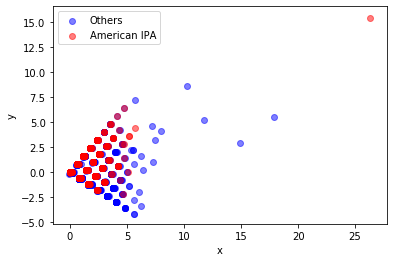

In [24]:
# Plot
red = (1,0,0)
blue = (0,0,1)
plt.scatter(X_NOIPA[:,0],X_NOIPA[:,1], c=blue, alpha=0.5)
plt.scatter(X_IPA[:,0],X_IPA[:,1], c=red, alpha=0.5)
plt.xlabel('x')
plt.ylabel('y')
plt.legend(['Others','American IPA'])
plt.show()